# Hyperparameter Tuning with MLJFlux

In this workflow example we learn how to tune different hyperparameters of MLJFlux models with emphasis on training hyperparameters.

**Julia version** is assumed to be 1.10.*

### Basic Imports

In [1]:
using MLJ               # Has MLJFlux models
using Flux              # For more flexibility
import RDatasets        # Dataset source
using Plots             # To plot tuning results

### Loading and Splitting the Data

In [2]:
iris = RDatasets.dataset("datasets", "iris");
y, X = unpack(iris, ==(:Species), colname -> true, rng=123);
X = Float32.(X);      # To be compatible with type of network network parameters

### Instantiating the model
Now let's construct our model. This follows a similar setup the one followed in the [Quick Start](../../index.md#Quick-Start).

In [3]:
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux
clf = NeuralNetworkClassifier(
    builder=MLJFlux.MLP(; hidden=(5,4), σ=Flux.relu),
    optimiser=Flux.ADAM(0.01),
    batch_size=8,
    epochs=10,
    rng=42
    )

[ Info: For silent loading, specify `verbosity=0`. 
import MLJFlux ✔


NeuralNetworkClassifier(
  builder = MLP(
        hidden = (5, 4), 
        σ = NNlib.relu), 
  finaliser = NNlib.softmax, 
  optimiser = Adam(0.01, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
  loss = Flux.Losses.crossentropy, 
  epochs = 10, 
  batch_size = 8, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = 42, 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

### Hyperparameter Tuning Example
Let's tune the batch size and the learning rate. We will use grid search and 5-fold cross-validation.

We start by defining the hyperparameter ranges

In [4]:
r1 = range(clf, :batch_size, lower=1, upper=64)
r2 = range(clf, :(optimiser.eta), lower=10^-4, upper=10^0, scale=:log10)

NumericRange(0.0001 ≤ optimiser.eta ≤ 1.0; origin=0.5, unit=0.5; on log10 scale)

Then passing the ranges along with the model and other arguments to the `TunedModel` constructor.

In [5]:
tuned_model = TunedModel(
    model=clf,
    tuning=Grid(goal=25),
    resampling=CV(nfolds=5, rng=42),
    range=[r1, r2],
    measure=cross_entropy,
);

Then wrapping our tuned model in a machine and fitting it.

In [6]:
mach = machine(tuned_model, X, y);
fit!(mach, verbosity=0);

Let's check out the best performing model:

In [7]:
fitted_params(mach).best_model

NeuralNetworkClassifier(
  builder = MLP(
        hidden = (5, 4), 
        σ = NNlib.relu), 
  finaliser = NNlib.softmax, 
  optimiser = Adam(0.1, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), 
  loss = Flux.Losses.crossentropy, 
  epochs = 10, 
  batch_size = 32, 
  lambda = 0.0, 
  alpha = 0.0, 
  rng = 42, 
  optimiser_changes_trigger_retraining = false, 
  acceleration = CPU1{Nothing}(nothing))

We can visualize the hyperparameter search results as follows

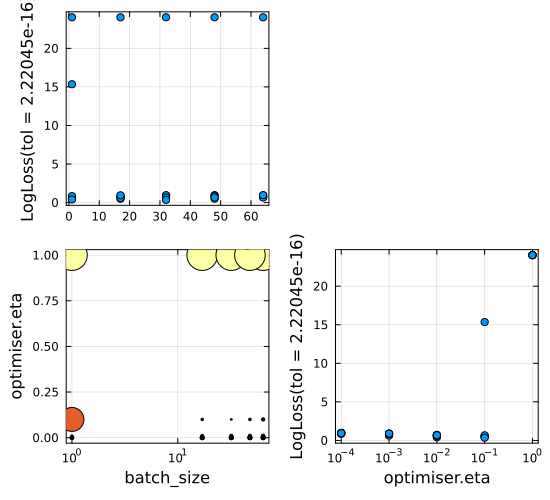

In [8]:
plot(mach)

### Learning Curves
With learning curves, it's possible to center our focus on the effects of a single hyperparameter of the model

First define the range and wrap it in a learning curve

In [9]:
r = range(clf, :epochs, lower=1, upper=200, scale=:log10)
curve = learning_curve(clf, X, y,
                       range=r,
                       resampling=CV(nfolds=4, rng=42),
                       measure=cross_entropy)

[ Info: Training machine(ProbabilisticTunedModel(model = NeuralNetworkClassifier(builder = MLP(hidden = (5, 4), …), …), …), …).
[ Info: Attempting to evaluate 25 models.
Evaluating over 25 metamodels: 100%[=========================] Time: 0:00:04


(parameter_name = "epochs",
 parameter_scale = :log10,
 parameter_values = [1, 2, 3, 4, 5, 6, 7, 9, 11, 13  …  39, 46, 56, 67, 80, 96, 116, 139, 167, 200],
 measurements = [0.8062291224242571, 0.7349032636328473, 0.6831822864090799, 0.6499205331218364, 0.6248770254396706, 0.606830885162984, 0.592554407591952, 0.5716582179222147, 0.5568372147591829, 0.5458850958793409  …  0.20880982517086102, 0.17360248501543618, 0.1304176223923372, 0.10766664152601196, 0.10348057744910813, 0.10307123308456925, 0.09357906967304538, 0.09787030345670497, 0.10027104135450549, 0.09926870681190969],)

Then plot the curve

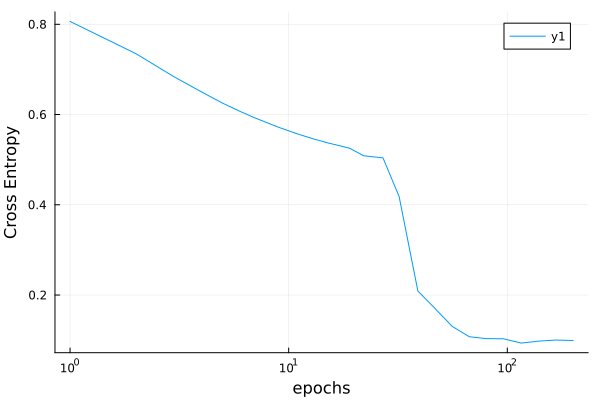

In [10]:
plot(curve.parameter_values,
       curve.measurements,
       xlab=curve.parameter_name,
       xscale=curve.parameter_scale,
       ylab = "Cross Entropy")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*